# Setup of Noteboook

The follwing code clones the github repository with course files. 
Subsequently it imports all libraries and custom modules needed for this notebook

In [245]:
!git clone https://github.com/DataHow/analytics-course-scripts.git
#!pip install --upgrade scipy==1.7.3

Cloning into 'analytics-course-scripts'...
remote: Enumerating objects: 224, done.
remote: Counting objects: 100% (224/224), done.
remote: Compressing objects: 100% (162/162), done.
remote: Total 224 (delta 122), reused 164 (delta 62), pack-reused 0
Receiving objects: 100% (224/224), 1.49 MiB | 4.42 MiB/s, done.
Resolving deltas: 100% (122/122), done.


In [247]:
# import libaries
#import pandas as pd
#import numpy as np
#import scipy
#import importlib  
#import scipy.integrate
#import plotly.express as px
#import plotly.graph_objects as go
#from plotly.subplots import make_subplots
#import statsmodels.api as sm
#from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import StandardScaler, PolynomialFeatures
#from sklearn.feature_selection import RFE
#from sklearn.linear_model import LinearRegression
#from sklearn.cross_decomposition import PLSRegression
#from sklearn.model_selection import GridSearchCV, validation_curve
#from sklearn.metrics import mean_squared_error

# import custom modules
#emulator = importlib.import_module("analytics-course-scripts.scripts.modules.emulator")
#modelhelpers = importlib.import_module("analytics-course-scripts.scripts.modules.modelhelpers")

In [272]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Gaussian Processes

In this script, we are investigating the main idea behind using Gaussian Processes and how conditional probability can be used to make predictions from data.
The idea is that we have a function that it is unknown to the use (originator function below). We sample the function in different "experiments" and we get noisy data in return.
We will use such data to construct a Gaussian Process.

## Create originator function

Here we first create an originator function that's nonlinear and with modifyable parameters.

In [273]:
# Fix seed
np.random.seed(42)
# Function parameters
x = np.array(range(1,7));
beta0 = 6;
beta1 = -3;
beta2 = 0.5;
sigma = 0.2;
# Originator function
def f(x, beta0=6, beta1=-3, beta2=0.5, sigma=0.2):
    return np.matmul(np.vstack((np.ones(len(x)), np.array(x), np.array(x) **2)).T,np.array([beta0,beta1,beta2])) + sigma*np.random.normal(0,1,len(x))

In [274]:
# Plot originator function with generated data
xgrid = np.arange(0,7,0.1)
fig = px.line(x=xgrid,y=f(xgrid,sigma=0),color=px.Constant("Originator function"), title = "Generated function we try to learn",labels=dict(x="x", y="y", color="Legend"))
fig.add_trace(go.Scatter(x=x,y=f(x),mode='markers',marker=dict(size=10),name="Generated data"))
fig.show()

### Generate data from the function

Now we can generate teh data from that function. Define the number of experiments, i.e. how many times the underlying process is sampled at the different values of x. To generate samples we slightly vary the underlying parameters.

In [275]:
# Generate data
no_exp = 25;

In [276]:
# Plot generated experiments
Y = np.zeros((no_exp,len(x)))
fig = px.scatter()
for n in range(no_exp):
    Y[n,:] = f(x,float(np.random.normal(size=1)*0.5+beta0),float(np.random.normal(size=1)*0.1+beta1),float(np.random.normal(size=1)*0.01+beta2))
    fig.add_trace(go.Scatter(x=x,y=Y[n,:],mode='lines',line=dict(color = 'rgb(49,130,189)')))
fig.update_layout(showlegend=False,title="Generated data",xaxis_title="x",yaxis_title="y")
fig.show()


## Conditional probability of next step

### Plot correlations

Here, we show as an example how the data at x=1 are correlated to those at x=2.
Below, we compute the mean of the function at each sampling point and the corresponding coviance/correlation matrices.


In [277]:
# Select x-axis step
select_x_step = 1
# Select y-axis step
select_y_step = 2

In [278]:
# Plot correlation between selected steps
fig = px.scatter(x=Y[:,select_x_step],y=Y[:,select_y_step], title = "Correlation between step x = "+str(select_x_step)+" and x = "+str(select_y_step)+" with correlation being "+str(np.round(np.corrcoef(Y[:,select_x_step],Y[:,select_y_step])[0,1],3)),labels=dict(x="Y(x = "+str(select_x_step)+")", y="Y(x = "+str(select_y_step)+")"))
fig.show()

Here we compute and visualize the mean, covariance, and correlation for all the steps.

In [279]:
Y_mu = np.mean(Y,axis=0)
Y_cov = np.cov(Y,rowvar=False)
Y_corr = np.corrcoef(Y,rowvar=False)
print('Mean: \n',pd.DataFrame(Y_mu).T)
print('\nCovariance: \n',pd.DataFrame(Y_cov))
print('\nCorrelation: \n',pd.DataFrame(Y_corr))

Mean: 
          0         1         2         3         4         5
0  3.41856  2.076548  1.638223  2.084442  3.640273  6.228154

Covariance: 
           0         1         2         3         4         5
0  0.226924  0.196476  0.184843  0.189247  0.196882  0.213099
1  0.196476  0.249935  0.215806  0.257875  0.273509  0.275973
2  0.184843  0.215806  0.237602  0.255222  0.250451  0.263694
3  0.189247  0.257875  0.255222  0.388584  0.371904  0.398079
4  0.196882  0.273509  0.250451  0.371904  0.454542  0.432896
5  0.213099  0.275973  0.263694  0.398079  0.432896  0.487167

Correlation: 
           0         1         2         3         4         5
0  1.000000  0.825002  0.796044  0.637304  0.613025  0.640918
1  0.825002  1.000000  0.885572  0.827471  0.811468  0.790887
2  0.796044  0.885572  1.000000  0.839945  0.762099  0.775062
3  0.637304  0.827471  0.839945  1.000000  0.884914  0.914929
4  0.613025  0.811468  0.762099  0.884914  1.000000  0.919935
5  0.640918  0.790887  0.775062  

### Using the correlations

If we define the correlation structure and suppose that the underlying probability density function is a multivariate normal distribution, we can sample from such distribution and generate new data.
Then we can plot all the pairs of data at x=1 and x=2 from such distribution.

In [280]:
# Define number of samples to generate from multivariate distribution
num_samples = 50
# Animate results
use_anim = False

In [281]:
Ym = np.random.multivariate_normal(Y_mu,Y_cov,100000)
if use_anim:
    trace1 = go.Scatter(x=[select_x_step,select_y_step],y=[Ym[n,select_x_step],Ym[n,select_y_step]],mode='lines')
    frames = [ dict(data = dict( type = 'scatter', x=[1,2],y=[Ym[k,1],Ym[k,2]])) for k in range(num_samples)]
    layout = go.Layout(showlegend=False, hovermode='x unified', updatemenus=[dict(type='buttons', showactive=False, y=1.05, x=1.15, xanchor='right', yanchor='top', pad=dict(t=0, r=10), buttons=[dict(label='Play simulations', method='animate',args=[None, dict(frame=dict(duration=50, redraw=False), transition=dict(duration=0), fromcurrent=True, mode='immediate')])] ) ])
    layout.update(xaxis =dict(range=[select_x_step-1,select_y_step+1]),yaxis =dict(range=[min(Ym[:,select_x_step]),max(Ym[:,select_x_step])]))
    fig = go.Figure(data=trace1, frames=frames, layout=layout)
    fig.update_layout(showlegend=False,title="Generated data",xaxis_title="x",yaxis_title="y")
    fig.show()
else:
    fig = px.scatter()
    for n in range(num_samples):
        fig.add_trace(go.Scatter(x=[select_x_step,select_y_step],y=[Ym[n,select_x_step],Ym[n,select_y_step]],mode='lines+markers',line=dict(color = 'rgb(49,130,189)')))
    fig.update_xaxes(range=[select_x_step-1,select_y_step+1])
    fig.update_layout(showlegend=False,title="Generated data",xaxis_title="x",yaxis_title="y")
    fig.show()

## Conditional probability given single observation

What is the distribution of $f(x)$ at $x=2$ assuming that $f(x=1) = 3$?
This is a typical conditional probability problem, where we have to "conditionally" sample from the original distribution.

Hence, we look at conditional probability $P(A | B)$ where $A: x=$ `a_step` and $B: f(x=$ `b_step` $)=$ `b_value`


In [282]:
# Probability of f(x) at step x equal to
select_a_step = 2 
# Given the observation of f(x) equal to
select_b_value = 3
# at the observation step x equal to
select_b_step = 1
# tolerance region for conditional probability calculation
tol = 0.01

In [283]:
rows = np.logical_and(Ym[:,select_b_step] > select_b_value -tol,Ym[:,select_b_step] > select_b_value +tol)
fig = px.histogram(Ym[rows,select_a_step],histnorm='probability density')
fig.update_layout(bargap=0.01,showlegend=False,title="Conditional Probability",xaxis_title="P(x="+str(select_a_step)+"|f(x="+str(select_b_step)+")="+str(select_b_value)+")",yaxis_title="Probability density")
fig.show()

Compute conditional probability exactly

In [284]:
mu_step = np.mean(Ym[rows,select_a_step])
std_step = np.std(Ym[rows,select_a_step])
print(mu_step)
print(std_step)

2.6204730793267226
0.2748003984625438


Hece, we can show conditional probability of the function given our observation

In [316]:
# Select number of simulations to plot
num_simulations = 1

In [317]:
fig = px.scatter()
for n in range(num_simulations):
    fig.add_trace(go.Scatter(x=[select_b_step,select_a_step],y=[select_b_value,Ym[rows,select_a_step][n]],mode='lines+markers',line=dict(color = 'rgb(49,130,189)')))
fig.add_trace(go.Scatter(x=[select_a_step,select_a_step],y=[mu_step-2*std_step,mu_step+2*std_step],mode='lines+markers',line=dict(color = px.colors.qualitative.G10[1])))
fig.add_trace(go.Scatter(x=[select_a_step,select_a_step],y=[mu_step,mu_step],mode='markers',marker=dict(size=10,color = px.colors.qualitative.G10[1])))
fig.add_trace(go.Scatter(x=[select_b_step,select_b_step],y=[select_b_value,select_b_value],mode='markers',marker=dict(size=10,color = 'rgb(49,130,189)')))
fig.update_layout(showlegend=False,title="Conditional Probability given observations",xaxis_title="x",yaxis_title="y")
fig.update_xaxes(range=[select_x_step-1,select_y_step+1])
fig.show()

## Conditional probability given observation for all steps


### Histogram of f(x) at day 2,3,4,5 given Y(x = 1) = 3

It is possible to repeat the exercize above, where we fixed the value of $f(x=1) = 3$. However, this time, we will check the probability of measuring $f(x)$ at $x = 2, 3, 4, 5$.
As shown in the correlation matrix above, values at these positions are correlated to those at $x = 1$, although the correlation descreses getting far away from $x = 1$, and so the corresponding uncertainty increases.

In [525]:
# Observation of f(x) equal to
select_b_value = 3
# Observation step x equal to
select_b_step = 1
# tolerance region for conditional probability calculation
tol = 0.01
# Compute conditional probabilities for remaining steps
step_1 = 2
step_2 = 3
step_3 = 4
step_4 = 5

In [526]:
rows = np.logical_and(Ym[:,select_b_step] > select_b_value -tol,Ym[:,select_b_step] > select_b_value +tol)

fig = go.Figure()
fig.add_trace(go.Histogram(x=Ym[rows,step_1],histnorm='probability density',name="x = "+str(step_1)))
fig.add_trace(go.Histogram(x=Ym[rows,step_2],histnorm='probability density',name="x = "+str(step_2)))
fig.add_trace(go.Histogram(x=Ym[rows,step_3],histnorm='probability density',name="x = "+str(step_3)))
fig.add_trace(go.Histogram(x=Ym[rows,step_4],histnorm='probability density',name="x = "+str(step_4)))

# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.update_layout(bargap=0.01,showlegend=True,title="Conditional Probability at all steps",xaxis_title="P(x="+str(step_1)+","+str(step_2)+","+str(step_3)+","+str(step_4)+" | f(x="+str(select_b_step)+")="+str(select_b_value)+")",yaxis_title="Probability density")
fig.show()

In [527]:
mu_1 = np.mean(Ym[rows,step_1])
mu_2 = np.mean(Ym[rows,step_2])
mu_3 = np.mean(Ym[rows,step_3])
mu_4 = np.mean(Ym[rows,step_4])
std_1 = np.std(Ym[rows,step_1])
std_2 = np.std(Ym[rows,step_2])
std_3 = np.std(Ym[rows,step_3])
std_4 = np.std(Ym[rows,step_4])
df_sum = pd.DataFrame(columns = ["steps","means"])
df_sum["steps"]= [step_1,step_2,step_3,step_4]
df_sum["means"]= [mu_1,mu_2,mu_3,mu_4]
print('\nMeans: \n',df_sum.to_string(index=False))
Y_corr = np.corrcoef(Ym[rows,step_1:step_4+1],rowvar=False)
print('\nCorrelations: \n',pd.DataFrame(Y_corr,columns=[step_1,step_2,step_3,step_4],index=[step_1,step_2,step_3,step_4]))



Means: 
  steps    means
     2 2.620473
     3 3.260479
     4 4.876307
     5 7.480019

Correlations: 
           2         3         4         5
2  1.000000  0.572363  0.378816  0.438685
3  0.572363  1.000000  0.713281  0.801894
4  0.378816  0.713281  1.000000  0.815681
5  0.438685  0.801894  0.815681  1.000000


### Visualizing corresponding function realizations.

In [528]:
# Select number of simulations to plot
num_simulations = 20

In [529]:
fig = px.scatter()
for n in range(num_simulations):
    fig.add_trace(go.Scatter(x=[select_b_step,step_1,step_2,step_3,step_4],y=np.concatenate((np.array(select_b_value),Ym[rows][:,[step_1,step_2,step_3,step_4]][n]),axis=None),mode='lines+markers',line=dict(color = 'rgb(49,130,189)')))
fig.add_trace(go.Scatter(x=[select_b_step,select_b_step],y=[select_b_value,select_b_value],mode='markers',marker=dict(size=10,color = 'rgb(49,130,189)')))
fig.add_trace(go.Scatter(x=[step_1,step_1],y=[mu_1-2*std_1,mu_1+2*std_1],mode='lines+markers',line=dict(color = px.colors.qualitative.G10[1])))
fig.add_trace(go.Scatter(x=[step_1,step_1],y=[mu_1,mu_1],mode='markers',marker=dict(size=10,color = px.colors.qualitative.G10[1])))
fig.add_trace(go.Scatter(x=[step_2,step_2],y=[mu_2-2*std_2,mu_2+2*std_2],mode='lines+markers',line=dict(color = px.colors.qualitative.G10[1])))
fig.add_trace(go.Scatter(x=[step_2,step_2],y=[mu_2,mu_2],mode='markers',marker=dict(size=10,color = px.colors.qualitative.G10[1])))
fig.add_trace(go.Scatter(x=[step_3,step_3],y=[mu_3-2*std_3,mu_3+2*std_3],mode='lines+markers',line=dict(color = px.colors.qualitative.G10[1])))
fig.add_trace(go.Scatter(x=[step_3,step_3],y=[mu_3,mu_3],mode='markers',marker=dict(size=10,color = px.colors.qualitative.G10[1])))
fig.add_trace(go.Scatter(x=[step_4,step_4],y=[mu_4-2*std_4,mu_4+2*std_4],mode='lines+markers',line=dict(color = px.colors.qualitative.G10[1])))
fig.add_trace(go.Scatter(x=[step_4,step_4],y=[mu_4,mu_4],mode='markers',marker=dict(size=10,color = px.colors.qualitative.G10[1])))
fig.update_layout(showlegend=False,title="Conditional Probability given observations",xaxis_title="x",yaxis_title="y")
fig.update_xaxes(range=[select_b_step-1,step_4+1])
fig.show()

## Conditional probability given multiple observations

Let's suppose to fix the starting point at $f(x=1) = 3$ and that at day $4$, $f(x=4) = 2$. What is the corresponding distribution of the Ys?

In [530]:
# Define the observations
obs_1_value = 3
obs_1_step = 1
# Define additional observation
obs_2_value = 5
obs_2_step = 4
# Remaining steps to do predictions at
step_1 = 2
step_2 = 3
step_3 = 5

# Specify tolerance
tol=0.01

In [531]:
rows = np.logical_and(np.logical_and(Ym[:,obs_1_step] > obs_1_value -tol,Ym[:,obs_1_step] > obs_1_value +tol),np.logical_and(Ym[:,obs_2_step] > obs_2_value -tol,Ym[:,obs_2_step] > obs_2_value +tol))

fig = go.Figure()
fig.add_trace(go.Histogram(x=Ym[rows,step_1],histnorm='probability density',name="x = "+str(step_1)))
fig.add_trace(go.Histogram(x=Ym[rows,step_2],histnorm='probability density',name="x = "+str(step_2)))
fig.add_trace(go.Histogram(x=Ym[rows,step_3],histnorm='probability density',name="x = "+str(step_3)))
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.75)
fig.update_layout(bargap=0.01,showlegend=True,title="Conditional Probability at all steps",xaxis_title="P(x="+str(step_1)+","+str(step_2)+","+str(step_3)+","+str(step_4)+" | f(x="+str(obs_1_step)+")="+str(obs_1_value)+", f(x="+str(obs_2_step)+")="+str(obs_2_value)+")",yaxis_title="Probability density")
fig.show()

In [534]:
mu_1 = np.mean(Ym[rows,step_1])
mu_2 = np.mean(Ym[rows,step_2])
mu_3 = np.mean(Ym[rows,step_3])
std_1 = np.std(Ym[rows,step_1])
std_2 = np.std(Ym[rows,step_2])
std_3 = np.std(Ym[rows,step_3])
df_sum = pd.DataFrame(columns = ["steps","means"])
df_sum["steps"]= [step_1,step_2,step_3]
df_sum["means"]= [mu_1,mu_2,mu_3]
print('\nMeans: \n',df_sum.to_string(index=False))
Y_corr = np.corrcoef(Ym[rows][:,[step_1,step_2,step_3]],rowvar=False)
print('\nCorrelations: \n',pd.DataFrame(Y_corr,columns=[step_1,step_2,step_3],index=[step_1,step_2,step_3]))



Means: 
  steps    means
     2 2.719852
     3 3.541594
     5 7.861890

Correlations: 
           2         3         5
2  1.000000  0.578858  0.381231
3  0.578858  1.000000  0.684833
5  0.381231  0.684833  1.000000


In [535]:
# Select number of simulations to plot
num_simulations = 1

In [536]:
fig = px.scatter()
for n in range(num_simulations):
    fig.add_trace(go.Scatter(x=[obs_1_step,step_1,step_2,obs_2_step,step_3],y=np.concatenate((obs_1_value,Ym[rows][:,[step_1,step_2]][n],obs_2_value,Ym[rows][:,[step_3]][n]),axis=None),mode='lines+markers',line=dict(color = 'rgb(49,130,189)')))
fig.add_trace(go.Scatter(x=[obs_1_step,obs_1_step],y=[obs_1_value,obs_1_value],mode='markers',marker=dict(size=10,color = 'rgb(49,130,189)')))
fig.add_trace(go.Scatter(x=[obs_2_step,obs_2_step],y=[obs_2_value,obs_2_value],mode='markers',marker=dict(size=10,color = 'rgb(49,130,189)')))
fig.add_trace(go.Scatter(x=[step_1,step_1],y=[mu_1-2*std_1,mu_1+2*std_1],mode='lines+markers',line=dict(color = px.colors.qualitative.G10[1])))
fig.add_trace(go.Scatter(x=[step_1,step_1],y=[mu_1,mu_1],mode='markers',marker=dict(size=10,color = px.colors.qualitative.G10[1])))
fig.add_trace(go.Scatter(x=[step_2,step_2],y=[mu_2-2*std_2,mu_2+2*std_2],mode='lines+markers',line=dict(color = px.colors.qualitative.G10[1])))
fig.add_trace(go.Scatter(x=[step_2,step_2],y=[mu_2,mu_2],mode='markers',marker=dict(size=10,color = px.colors.qualitative.G10[1])))
fig.add_trace(go.Scatter(x=[step_3,step_3],y=[mu_3-2*std_3,mu_3+2*std_3],mode='lines+markers',line=dict(color = px.colors.qualitative.G10[1])))
fig.add_trace(go.Scatter(x=[step_3,step_3],y=[mu_3,mu_3],mode='markers',marker=dict(size=10,color = px.colors.qualitative.G10[1])))
fig.update_layout(showlegend=False,title="Conditional Probability given observations",xaxis_title="x",yaxis_title="y")
fig.update_xaxes(range=[obs_1_step-1,step_3+1])
fig.show()

# Kernels in Gaussian Processes

In this section, we will try to learn an unknown function ("originator function" below) using few samples.

The key point is the definition of a the kernel function, which is defining the similarity among data. The key parameter is sigma, which define the so-called similarity scale.

In the following, we will show how these simple concepts can be put together to predict the falue of the unknown function away from the data, and which is the behavior of the Guassian Process model in responce to changes in the model parameters.


### Create originator function

Similarly as above, we define a function which we try to learn

In [520]:
# Define observations
x = np.zeros(3);
x[0] = 2; # position of first observation
x[1] = 5; # position of second observation
x[2] = 8; # position of third observation
# Fix seed
np.random.seed(10)
# Function parameters
beta0 = 6
beta1 = -3
beta2 = 0.5
beta3 = -0.25
eps = 0
# Originator function
def f(x, beta0=6, beta1=-3, beta2=0.5, beta3=-0.025,eps=0):
    return np.matmul(np.vstack((np.ones(len(x)), np.array(x), np.array(x) **2,np.array(x) **3)).T,np.array([beta0,beta1,beta2,beta3])) + sigma*np.random.normal(0,1,len(x))
# Kernel parameters
sigma = 2;
# Kernel function
def kernel_fcn(xi,xj,sigma=2):
    return np.exp(-0.5*((xi-xj)/sigma)**2)

In [521]:
y = f(x) 
# Plot originator function with generated data
xgrid = np.arange(0,12,0.1)
fig = px.line(x=xgrid,y=f(xgrid),color=px.Constant("Originator function"), title = "Generated function we try to learn",labels=dict(x="x", y="y", color="Legend"))
fig.add_trace(go.Scatter(x=x,y=f(x),mode='markers',marker=dict(size=10),name="Generated data"))
fig.show()

### Create a kernel function


The user can select different values of the similarity scale (sigma).
For better understanding, we are plotting the value of the similarity (kernel) function centered on the second observation (i.e., the kernel is $= 1$ in $x(2)$).

In [522]:
# Kernel parameters
sigma = 2;
# Kernel function
def kernel_fcn(xi,xj,sigma=2):
    return np.exp(-0.5*((xi-xj)/sigma)**2)

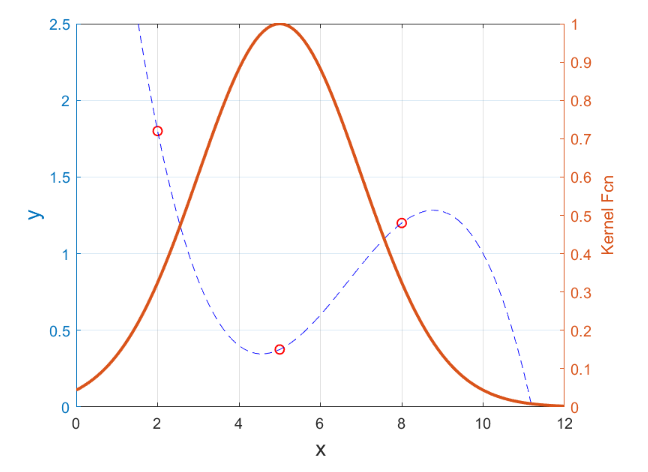

Compute the kernel matrix

In [ ]:
no_data = len(x);
K = np.zeros(no_data);
for i = range(no_data):
    K[i,:] = Kernel_fcn(x(i),x,sigma);
K

### Add new observation point

The user can define a new observation point, where we want to predict the function.
The new observation will be added in the first position of the new kernel matrix, which is now 4x4, and it is calculated below.


In [ ]:
x_pred = 6;
K_pred = zeros(no_data+1);
K_pred(2:no_data+1,2:no_data+1) = K
K_pred(:,1) = Kernel_fcn(x_pred,[x_pred;x],sigma);
K_pred(1,:) = K_pred(:,1)'

### Create the covariance matrix

A second parameter is needed, which is the variance of the observation. This parameter is defining the prior knowldge.

In [ ]:
sigma_y = 2;
cov_matrix = sigma_y*K_pred

### Create multivariate distribution


Create the conditional multivariate distribution for the new observation point, given the other observations.

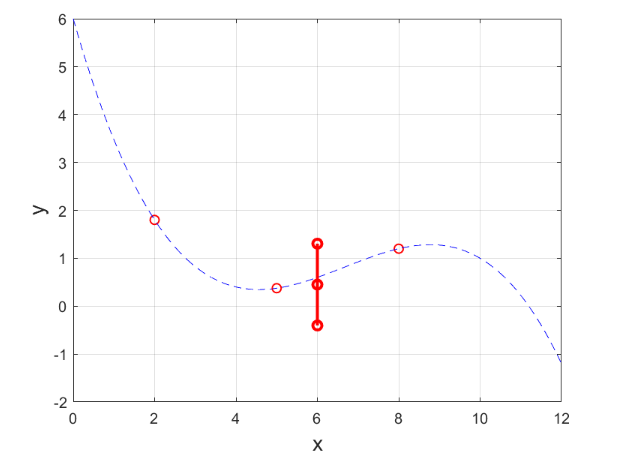

### Compute predictions for all x

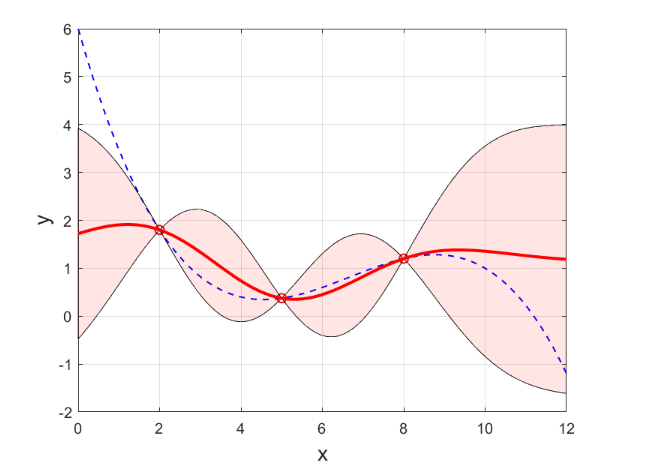

### Effect of error in measurment


Her we simulate the effect of measurement error on the model. We suppose of sampling twice the function with 6 regular points.

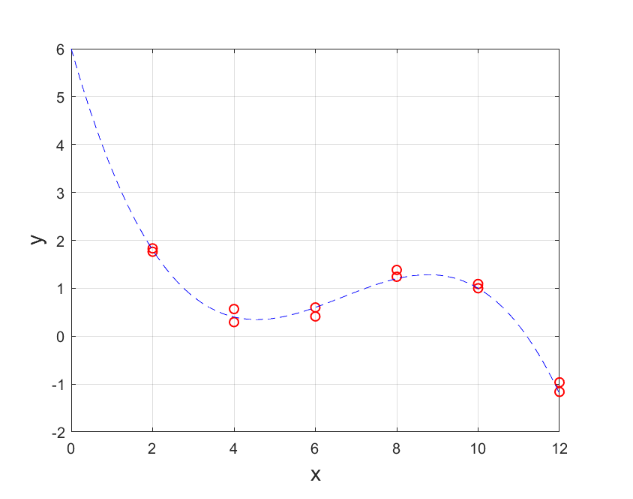

We compute the kernel

In [ ]:
no_data = len(x);
K = np.zeros(no_data);
for i = range(no_data)
    K(i,:) = Kernel_fcn(x(i),x,sigma)
K

And create predictions

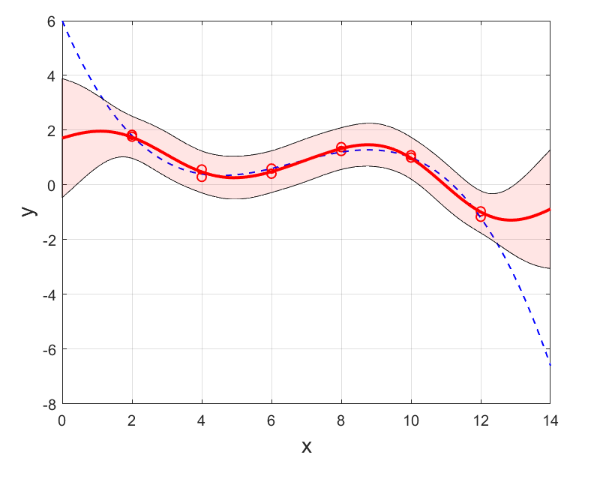

# Task: 

